### Acquire Data

In [ ]:
# Download data we need: If directory "data/" already exists, we'll assume the data are already downloaded.
# The files are 381 MB zipped and 1.2 GB unzipped
# Retrieving these files from NOAA takes 30-60 seconds on a home internet connection.

import os, urllib, zipfile
import os, urllib, zipfile
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings("ignore")
dir_data = '/kaggle/input/'
if not os.path.isdir(dir_data):
    os.mkdir(dir_data)

    # Zenodo URLs
    #urls = ['https://zenodo.org/record/8197443/files/public.zip?download=1',
    #        'https://zenodo.org/record/8197443/files/private.zip?download=1']

    # NOAA URLs (same exact data as on Zenodo) -- uncomment to download from NOAA
    urls = ['https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip',
         'https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip']

    # Download and unzip each file
    for url in urls:
        zip_path, _ = urllib.request.urlretrieve(url)
        with zipfile.ZipFile(zip_path, "r") as f:
            print('Downloaded ', url, ', now unzipping.')
            f.extractall(dir_data)

# Print list of data files:
print('\nData files for input (features) and output Dst (labels):')
for dir_pubpriv in ['noaa-public/', 'noaa-private/']:
    print(dir_data+dir_pubpriv)
    for path, dirs, files in os.walk(dir_data+dir_pubpriv):
        for f in files: print('\t', f)


Data files for input (features) and output Dst (labels):
/kaggle/input/noaa-public/
	 solar_wind.csv
	 satellite_positions.csv
	 dst_labels.csv
	 sunspots.csv
/kaggle/input/noaa-private/
	 solar_wind.csv
	 satellite_positions.csv
	 dst_labels.csv
	 sunspots.csv


In [ ]:
# Modules we need to get started and Matplotlib configuration:
import numpy as np, pandas as pd, pprint
import matplotlib.pyplot as plt

# The next two lines are nice for Jupyter, but not available for Colab:
#%load_ext nb_black
#%matplotlib inline

# Matplotlib Configuration
import matplotlib.pyplot as plt
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

#### Import  Input (Features) and Output (Labels) as Pandas DataFrames
<div class="alert alert-block alert-info">
<b>Info:</b> As described above, the input data is a time series of solar wind measurements at L1 along with sunspot number, and the output data is a time series of <i>Dst</i>. Recall that for the past competition, the competitors did not have the real geophysical date/time. So here, we will recreate a new column of real geophysical date/time from our timedelta and the table shown in "Data Summary".
</div>

In [ ]:
# From our time range table in the "Data Summary" section:
period_ranges = {
    'period_1':[pd.Timestamp('1998/2/16 00:00:00'), pd.Timestamp('2001/5/31  23:59:00')],
    'period_2':[pd.Timestamp('2013/6/1  00:00:00'), pd.Timestamp('2019/5/31  23:59:00')],
    'period_3':[pd.Timestamp('2004/5/1  00:00:00'), pd.Timestamp('2010/12/31 23:59:00')],
    'period_4' :[pd.Timestamp('2001/6/1  00:00:00'), pd.Timestamp('2004/4/30  23:59:00')],
    'period_5' :[pd.Timestamp('2011/1/1  00:00:00'), pd.Timestamp('2013/5/31  23:59:00')],
    'period_6' :[pd.Timestamp('2019/6/1  00:00:00'), pd.Timestamp('2020/10/31 23:59:00')]}

def convert_timedelta_to_datetime( df ):
    """Adds real geophysical datetimes to our DataFrame using the original "index" timestamps.

    The relative "index" timestamps were used in the MagNet competition datasets since all of the data
    were in the public domain.

    Parameters
    ----------
    df: pd.DataFrame
        Includes index time

    Returns
    -------
    df_datetimes: pd.DataFrame
        Adds datetimes to the input pd.DataFrame
    """
    df_datetimes = pd.DataFrame(index=df.index)
    df_datetimes['datetime'] = pd.NaT     # like Numpy NaN

    i = 0
    for period_name, timedelta in df.index:
        start_time = period_ranges[period_name][0]
        datetime = timedelta + start_time                 # add Pandas Timedelta to Pandas Timestamp
        df_datetimes['datetime'].values[i] = datetime
        i += 1

        #print('%s: %s + %s = %s' % (period_name, timedelta, start_time, df['datetime'].values[i]))

    return df_datetimes

In [ ]:
# Assuming you have your DataFrame as df
# Create a dictionary to map the old values to the new ones
mapping = {
    'train_a': 'period_1',
    'train_b': 'period_2',
    'train_c': 'period_3',
    'test_a': 'period_4',
    'test_b': 'period_5',
    'test_c': 'period_6',
    # Add more mappings for other train types if needed
}

In [ ]:
# Import as Pandas DataFrames
from pathlib import Path
DATA_PATH = Path("/kaggle/input/noaa-public/")

print('Reading in the Dst output data...')
dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst['period'] = dst['period'].map(mapping)
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots['period'] = sunspots['period'].map(mapping)
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind['period'] = solar_wind['period'].map(mapping)
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions['period'] = satellite_positions['period'].map(mapping)
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)


Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


In [ ]:
dst

dst
period   timedelta              
period_1 0 days 00:00:00      -7
         0 days 01:00:00     -10
         0 days 02:00:00     -10
         0 days 03:00:00      -6
         0 days 04:00:00      -2
...                          ...
period_3 2435 days 19:00:00  -16
         2435 days 20:00:00  -14
         2435 days 21:00:00  -14
         2435 days 22:00:00  -15
         2435 days 23:00:00  -14

[139872 rows x 1 columns]

In [ ]:
# Real Event Data that was previously held back from the competitors
DATA_PATH2 = Path("/kaggle/input/noaa-private/")
print('Importing data from: %s' % DATA_PATH)

print('Reading in the Dst output data...')
dst2 = pd.read_csv(DATA_PATH2 / "dst_labels.csv")
dst2['period'] = dst2['period'].map(mapping)
dst2.timedelta = pd.to_timedelta(dst2.timedelta)
dst2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Sunspot input data...')
sunspots2 = pd.read_csv(DATA_PATH2 / "sunspots.csv")
sunspots2['period'] = sunspots2['period'].map(mapping)
sunspots2.timedelta = pd.to_timedelta(sunspots2.timedelta)
sunspots2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Solarwind input data...')
solar_wind2 = pd.read_csv(DATA_PATH2 / "solar_wind.csv")
solar_wind2['period'] = solar_wind2['period'].map(mapping)
solar_wind2.timedelta = pd.to_timedelta(solar_wind2.timedelta)
solar_wind2.set_index(["period", "timedelta"], inplace=True)

print('Reading in the Satellite position input data...')
satellite_positions2 = pd.read_csv(DATA_PATH2 / "satellite_positions.csv")
satellite_positions2['period'] = satellite_positions2['period'].map(mapping)
satellite_positions2.timedelta = pd.to_timedelta(satellite_positions2.timedelta)
satellite_positions2.set_index(["period", "timedelta"], inplace=True)

Importing data from: /kaggle/input/noaa-public
Reading in the Dst output data...
Reading in the Sunspot input data...
Reading in the Solarwind input data...
Reading in the Satellite position input data...


In [ ]:
print("Dst shape: ", dst.shape)
dst.head()

Dst shape:  (139872, 1)


dst
period   timedelta           
period_1 0 days 00:00:00   -7
         0 days 01:00:00  -10
         0 days 02:00:00  -10
         0 days 03:00:00   -6
         0 days 04:00:00   -2

In [ ]:
dst.groupby("period").describe()

dst                                                    
            count       mean        std    min   25%   50%  75%   max
period                                                               
period_1  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
period_2  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
period_3  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

In [ ]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head()

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period   timedelta                                                             
period_1 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
         0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
         0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   
         0 days 00:03:00   -5.20    3.68    0.68       6.17   146.17   -5.20   
         0 days 00:04:00   -5.12    3.68    0.49       4.62   145.72   -5.12   

                          by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period   timedelta                                                            
period_1 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
         0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
         0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   
         0 days 00:03:00    3.68    0.68       6.17   146.17  6.74     1.97   
         0 days 00:04:00    3.68    0.49       4.62   145.72  6.65     1.77   

                           speed  temperature source  
period   timedelta                                    
period_1 0 days 00:00:00  383.92     110237.0     ac  
         0 days 00:01:00  381.79     123825.0     ac  
         0 days 00:02:00  389.11      82548.0     ac  
         0 days 00:03:00  389.11      82548.0     ac  
         0 days 00:04:00  384.26      94269.0     ac

In [ ]:
solar_wind.groupby("period").describe().T

period                 period_1      period_2      period_3
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [ ]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head()

Sunspot shape:  (192, 1)


smoothed_ssn
period   timedelta              
period_1 0 days             65.4
         13 days            72.0
         44 days            76.9
         74 days            80.8
         105 days           85.4

In [ ]:
sunspots.groupby("period").describe().T

period                period_1    period_2   period_3
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

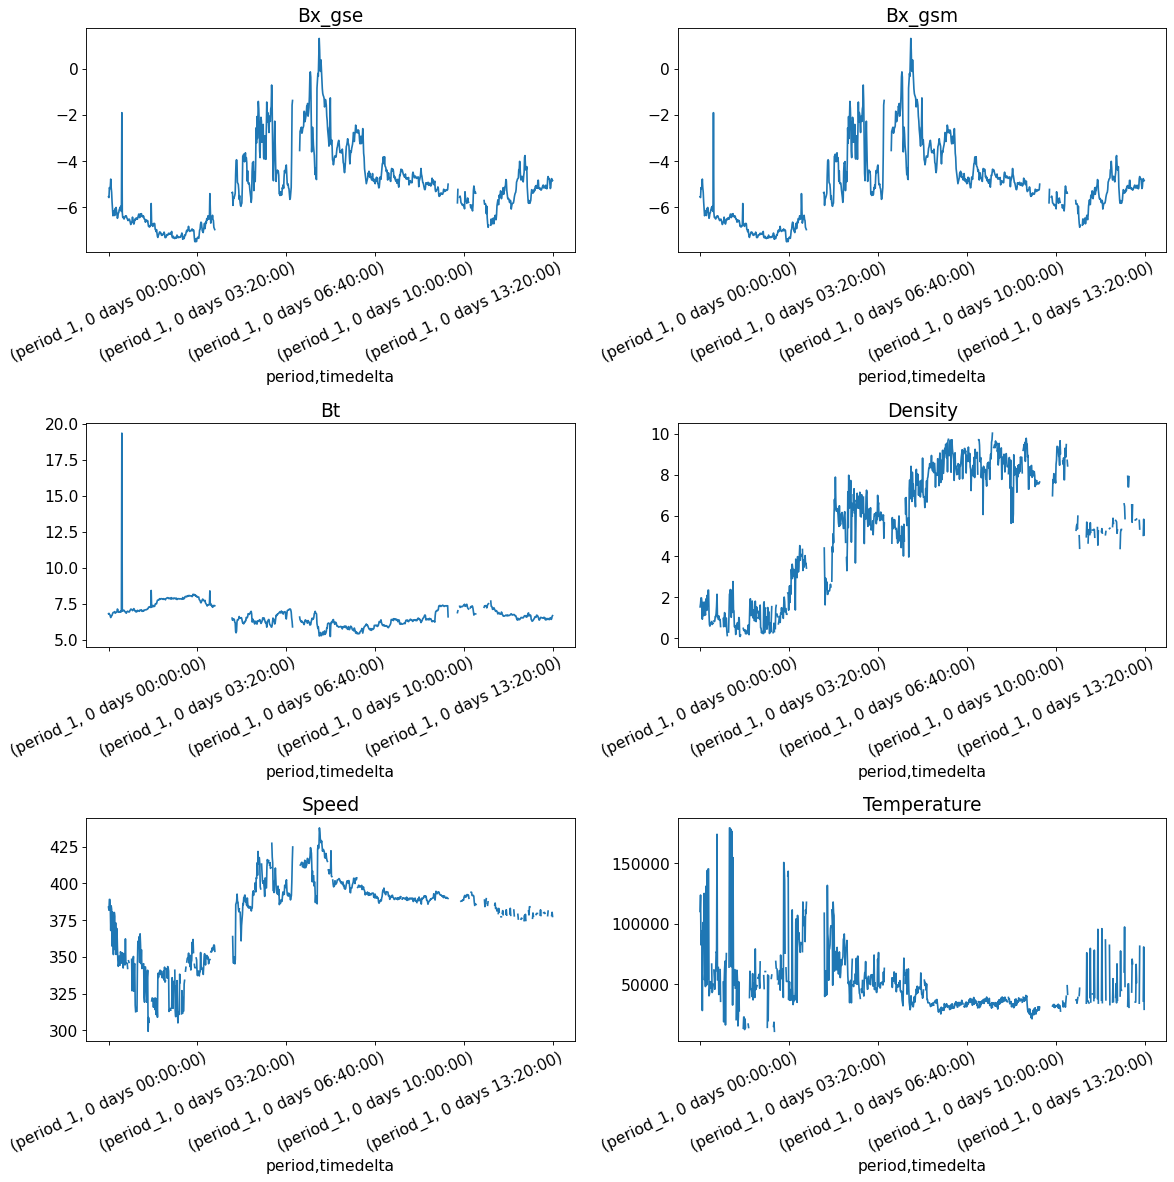

In [ ]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()


cols_to_plot = ["bx_gse", "bx_gsm", "bt", "density", "speed", "temperature"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

In [ ]:
solar_wind.isna().sum()

bx_gse         325888
by_gse         325888
bz_gse         325888
theta_gse      325888
phi_gse        326388
bx_gsm         325888
by_gsm         325888
bz_gsm         325888
theta_gsm      325888
phi_gsm        326388
bt             325888
density        684890
speed          689555
temperature    811768
source         316816
dtype: int64

In [ ]:
solar_wind.join(sunspots).join(dst)

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period   timedelta                                                        
period_1 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37   
         0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91   
         0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04   
         0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17   
         0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72   
...                             ...     ...     ...        ...      ...   
period_3 2435 days 23:55:00   -1.18    2.00   -3.92     -59.28   120.51   
         2435 days 23:56:00   -1.34    2.12   -3.83     -56.78   122.23   
         2435 days 23:57:00   -1.62    2.33   -3.63     -51.98   124.76   
         2435 days 23:58:00   -2.27    2.48   -3.22     -43.81   132.50   
         2435 days 23:59:00   -2.15    2.41   -3.30     -45.55   131.76   

                             bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period   timedelta                                                              
period_1 0 days 00:00:00      -5.55    3.00    1.25      11.09   153.37  6.80   
         0 days 00:01:00      -5.58    3.16    1.17      10.10   151.91  6.83   
         0 days 00:02:00      -5.15    3.66    0.85       7.87   146.04  6.77   
         0 days 00:03:00      -5.20    3.68    0.68       6.17   146.17  6.74   
         0 days 00:04:00      -5.12    3.68    0.49       4.62   145.72  6.65   
...                             ...     ...     ...        ...      ...   ...   
period_3 2435 days 23:55:00   -1.17    2.98   -3.23     -45.24   111.48  4.56   
         2435 days 23:56:00   -1.33    3.08   -3.12     -42.95   113.45  4.58   
         2435 days 23:57:00   -1.61    3.22   -2.87     -38.57   116.58  4.61   
         2435 days 23:58:00   -2.26    3.25   -2.44     -31.61   124.81  4.65   
         2435 days 23:59:00   -2.15    3.21   -2.53     -33.21   123.75  4.62   

                             density   speed  temperature source  \
period   timedelta                                                 
period_1 0 days 00:00:00        1.53  383.92     110237.0     ac   
         0 days 00:01:00        1.69  381.79     123825.0     ac   
         0 days 00:02:00        1.97  389.11      82548.0     ac   
         0 days 00:03:00        1.97  389.11      82548.0     ac   
         0 days 00:04:00        1.77  384.26      94269.0     ac   
...                              ...     ...          ...    ...   
period_3 2435 days 23:55:00     4.64  348.73      23368.0     ac   
         2435 days 23:56:00     4.27  346.36      26497.0     ac   
         2435 days 23:57:00     3.95  344.12      27050.0     ac   
         2435 days 23:58:00     2.81  338.52      33257.0     ac   
         2435 days 23:59:00     2.30  342.31      32267.0     ac   

                             smoothed_ssn  dst  
period   timedelta                              
period_1 0 days 00:00:00             65.4 -7.0  
         0 days 00:01:00              NaN  NaN  
         0 days 00:02:00              NaN  NaN  
         0 days 00:03:00              NaN  NaN  
         0 days 00:04:00              NaN  NaN  
...                                   ...  ...  
period_3 2435 days 23:55:00           NaN  NaN  
         2435 days 23:56:00           NaN  NaN  
         2435 days 23:57:00           NaN  NaN  
         2435 days 23:58:00           NaN  NaN  
         2435 days 23:59:00           NaN  NaN  

[8392320 rows x 17 columns]

In [ ]:
solar_wind2.join(sunspots).join(dst)

bx_gse  by_gse  bz_gse  theta_gse  phi_gse  \
period   timedelta                                                       
period_4 0 days 00:00:00     -3.35    3.44   -1.01     -11.91   134.18   
         0 days 00:01:00     -2.98    3.59   -1.04     -12.52   129.71   
         0 days 00:02:00     -3.29    3.46   -1.04     -12.33   133.54   
         0 days 00:03:00     -3.39    3.44   -0.79      -9.29   134.57   
         0 days 00:04:00     -3.28    3.52   -0.86     -10.13   132.99   
...                            ...     ...     ...        ...      ...   
period_6 518 days 23:55:00   -3.35   -2.14    2.85      35.69   212.55   
         518 days 23:56:00   -2.39    0.21    1.45      31.07   174.91   
         518 days 23:57:00   -0.78    2.75   -0.39      -7.73   105.85   
         518 days 23:58:00   -0.23    3.71   -0.93     -14.01    93.58   
         518 days 23:59:00    0.12    3.97   -0.17      -2.47    88.26   

                            bx_gsm  by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  \
period   timedelta                                                             
period_4 0 days 00:00:00     -3.35    3.59    0.14       1.65   133.00  4.91   
         0 days 00:01:00     -2.98    3.73    0.17       1.98   128.61  4.78   
         0 days 00:02:00     -3.29    3.62    0.12       1.34   132.29  4.89   
         0 days 00:03:00     -3.39    3.51    0.35       4.09   133.97  4.89   
         0 days 00:04:00     -3.28    3.61    0.31       3.59   132.26  4.88   
...                            ...     ...     ...        ...      ...   ...   
period_6 518 days 23:55:00   -3.35   -1.64    3.16      40.32   206.13  4.89   
         518 days 23:56:00   -2.39    0.45    1.39      29.78   169.42  3.01   
         518 days 23:57:00   -0.78    2.65   -0.83     -16.78   106.42  2.96   
         518 days 23:58:00   -0.23    3.51   -1.52     -23.43    93.78  3.86   
         518 days 23:59:00    0.12    3.89   -0.82     -11.91    88.23  3.98   

                            density   speed  temperature source  smoothed_ssn  \
period   timedelta                                                              
period_4 0 days 00:00:00       5.57  338.59      41313.0     ac           NaN   
         0 days 00:01:00       5.66  339.11      37388.0     ac           NaN   
         0 days 00:02:00       4.95  337.70      35715.0     ac           NaN   
         0 days 00:03:00       4.96  338.41      38214.0     ac           NaN   
         0 days 00:04:00       5.35  336.63      40458.0     ac           NaN   
...                             ...     ...          ...    ...           ...   
period_6 518 days 23:55:00     4.64  388.30     111784.0     ds           NaN   
         518 days 23:56:00     5.35  390.90     123559.0     ds           NaN   
         518 days 23:57:00     5.63  411.60     120740.0     ds           NaN   
         518 days 23:58:00     5.65  416.60     100777.0     ds           NaN   
         518 days 23:59:00     5.93  415.80      89069.0     ds           NaN   

                            dst  
period   timedelta               
period_4 0 days 00:00:00    NaN  
         0 days 00:01:00    NaN  
         0 days 00:02:00    NaN  
         0 days 00:03:00    NaN  
         0 days 00:04:00    NaN  
...                         ...  
period_6 518 days 23:55:00  NaN  
         518 days 23:56:00  NaN  
         518 days 23:57:00  NaN  
         518 days 23:58:00  NaN  
         518 days 23:59:00  NaN  

[3551040 rows x 17 columns]

In [ ]:
solar_wind.drop('source',axis=1, inplace=True)
solar_wind2.drop('source',axis=1, inplace=True)

### Feature Relationships

Data gaps in the Solar Wind data are a common issue with real-time data

<div class="alert alert-block alert-warning">
<b>Be Aware:</b> Gaps in our input (features) are something we'll need to deal carefully with, i.e. in the preprocessing steps below.
</div>

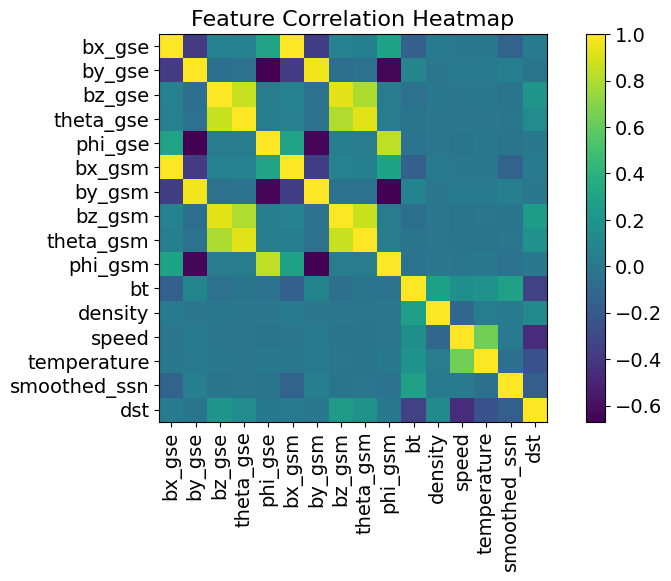

In [ ]:
corr = solar_wind.join(sunspots).join(dst).fillna(method="pad").corr()
corr = solar_wind.join(sunspots).join(dst).fillna(method="bfill").corr()
plt.figure(figsize=(10, 5))
plt.matshow(corr, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

<div class="alert alert-block alert-info">
<b>Info: </b>There are several challenges when working with these "operational" observations of the solar wind we will need to solve before modeling (e.g. missing data).
</div>

### Feature Generation

#### Set seeds for reproducibility

In [ ]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

#### Feature / Input Data we'll use to Train the Model

<div class="alert alert-block alert-info">
<b>Info: </b> It's good to think about what features we'd recommend for use in developing our model. An additional exercise at the end of this notebook has learners try different sets of features. You can do so simply by adjusting the "SOLAR_WIND_FEATURES" list below.
</div>

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler,power_transform
from sklearn.impute import  SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PowerTransformer
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    #"bx_gse",
    #"by_gse",
    #"bz_gse",
    #"phi_gse",
    #"theta_gse",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    #"phi_gsm",
    #"theta_gsm",
    "speed",
    "density",
]


In [ ]:
# The model will be built on feature statistics, mean and standard deviation
# all of the features we'll use, including sunspot numbers
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

<div class="alert alert-block alert-info">
<b>Info: </b>As discussed above, we'll need to fill in gaps and create statistical summaries (hourly means and standard deviations) of our features before modeling. The following routines provide this "preprocessing" functionality of gap filling, and scaling by features' statistics.
</div>

In [ ]:
from sklearn.preprocessing import StandardScaler

def impute_features(feature_df, imp = None):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # missing solar wind values imputation using most-frequent strategy
    feature_df=feature_df.reset_index()
    cols = feature_df.columns[2:]
    if imp == None:
        imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imp.fit(feature_df[cols])
    temp = imp.transform(feature_df[cols])
    feature_df[cols] = temp
    feature_df.timedelta = pd.to_timedelta(feature_df.timedelta)
    feature_df.set_index(["period", "timedelta"], inplace=True)
    return feature_df , imp


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None,imputer=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]
    # aggregate solar wind data and join with sunspots

    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed, imp = impute_features(normalized,imputer)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler, imp

In [ ]:
features, scaler, imputer = preprocess_features(solar_wind, sunspots , subset=SOLAR_WIND_FEATURES)
print(features.shape)
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()
features.head()

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period   timedelta                                               
period_1 0 days 00:00:00  0.499705  2.443614         -0.375267   
         0 days 01:00:00  0.547177 -0.224580         -0.479430   
         0 days 02:00:00  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.600307   -0.381727   
         0 days 01:00:00         0.953178    -1.759200   -0.868044   
         0 days 02:00:00        -0.192518    -1.913422   -1.114649   
         0 days 03:00:00         0.325491    -1.810283   -0.783326   
         0 days 04:00:00         0.201600    -1.339730   -0.485151   

                          by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                           
period_1 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
         0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
         0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
         0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
         0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                          speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                           
period_1 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
         0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
         0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
         0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
         0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                          smoothed_ssn  
period   timedelta                      
period_1 0 days 00:00:00      0.139444  
         0 days 01:00:00      0.139444  
         0 days 02:00:00      0.139444  
         0 days 03:00:00      0.139444  
         0 days 04:00:00      0.139444

In [ ]:
features2, scaler2, imputer2 = preprocess_features(solar_wind2, sunspots2 , subset=SOLAR_WIND_FEATURES)
print(features2.shape)
# check to make sure missing values are filled
assert (features2.isna().sum() == 0).all()
features2.head()

(59184, 15)


bt_mean    bt_std  temperature_mean  \
period   timedelta                                               
period_4 0 days 00:00:00 -0.311506 -0.166852         -0.670084   
         0 days 01:00:00 -0.257180 -0.121644         -0.633529   
         0 days 02:00:00 -0.113797 -0.179912         -0.626987   
         0 days 03:00:00  0.007134 -0.614577         -0.627023   
         0 days 04:00:00 -0.042030 -0.260113         -0.553776   

                          temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                   
period_4 0 days 00:00:00        -0.546331    -0.758353   -0.583996   
         0 days 01:00:00        -0.547793    -0.788554   -0.357552   
         0 days 02:00:00        -0.484512    -1.043605   -0.444780   
         0 days 03:00:00        -0.582198    -1.176884   -0.991882   
         0 days 04:00:00        -0.488325    -1.218106   -0.621391   

                          by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                           
period_4 0 days 00:00:00     0.921260   -0.515805     0.166885   -0.088773   
         0 days 01:00:00     0.874534   -0.646606    -0.544606   -0.446676   
         0 days 02:00:00     0.846197   -0.579697     0.202947   -0.101880   
         0 days 03:00:00     0.880797   -0.946969     0.390546   -0.895758   
         0 days 04:00:00     0.685410   -0.636967     0.253243   -0.275533   

                          speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                           
period_4 0 days 00:00:00   -0.908184  -0.619373      0.360563    -0.284825   
         0 days 01:00:00   -0.941623  -0.752956      0.369791    -0.250942   
         0 days 02:00:00   -0.950062  -0.702432      0.389097    -0.189137   
         0 days 03:00:00   -0.988391  -0.852211      0.219304    -0.342911   
         0 days 04:00:00   -1.082263  -0.355499      0.280538     0.013268   

                          smoothed_ssn  
period   timedelta                      
period_4 0 days 00:00:00      1.416715  
         0 days 01:00:00      1.416715  
         0 days 02:00:00      1.416715  
         0 days 03:00:00      1.416715  
         0 days 04:00:00      1.416715

<div class="alert alert-block alert-info">
<b>Info:</b> We also need to prepare our output (labels), i.e. our space weather storm index <i>Dst</i>, which is already a time series with an hourly cadence. The modeling task is to predict <i>Dst</i> at hour t0 and the next hour t1.
</div>

In [ ]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    """Create dst[t0] (current time) and dst[t1] (next hour) labels and group by training periods.

    This is needed because we wish to train the model on predicting Dst at the current time (t0)
    and for the next hour (t1). The method is a simple Pandas DataFrame array timeshift from dst[0:] to get dst[1:].

    Parameters
    ----------
    dst : pd.DataFrame

    Returns
    -------
    y : pd.DataFrame
        New copy of dst pd.DataFrame now including shifted Dst, and is grouped by training period.
        This is what we will train the model on.
    """

    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift( 0)
    y["t1"] = y.groupby("period").dst.shift(-1)
    return y[YCOLS]


labels = process_labels(dst)
labels.head(n=5)

t0    t1
period   timedelta                
period_1 0 days 00:00:00  -7 -10.0
         0 days 01:00:00 -10 -10.0
         0 days 02:00:00 -10  -6.0
         0 days 03:00:00  -6  -2.0
         0 days 04:00:00  -2   3.0

In [ ]:
data = labels.join(features)
data.head()

t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                         
period_1 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
         0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
         0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.600307   -0.381727   
         0 days 01:00:00         0.953178    -1.759200   -0.868044   
         0 days 02:00:00        -0.192518    -1.913422   -1.114649   
         0 days 03:00:00         0.325491    -1.810283   -0.783326   
         0 days 04:00:00         0.201600    -1.339730   -0.485151   

                          by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                           
period_1 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
         0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
         0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
         0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
         0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                          speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                           
period_1 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
         0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
         0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
         0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
         0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                          smoothed_ssn  
period   timedelta                      
period_1 0 days 00:00:00      0.139444  
         0 days 01:00:00      0.139444  
         0 days 02:00:00      0.139444  
         0 days 03:00:00      0.139444  
         0 days 04:00:00      0.139444

In [ ]:
labels2 = process_labels(dst2)
data2 = labels2.join(features2)

<div class="alert alert-block alert-info">
<b>Tip:</b> For convenience, join our processed solar wind hourly inputs (features) and our <i>Dst</i> (labels) into one Pandas DataFrame.
</div>

### Splitting the Data

<div class="alert alert-block alert-info">
<b>Info:</b> We'll split our features and labels into Training, Testing and Validation sets for each of the 3 training periods, named train_a, train_b, train_c (see Data Summary for additional details).
</div>

In [ ]:
data = pd.concat([data, data2], axis=0)
data

t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                           
period_1 0 days 00:00:00    -7 -10.0  0.499705  2.443614         -0.375267   
         0 days 01:00:00   -10 -10.0  0.547177 -0.224580         -0.479430   
         0 days 02:00:00   -10  -6.0  0.739905 -0.770240         -0.574831   
         0 days 03:00:00    -6  -2.0  0.699098 -0.278783         -0.324709   
         0 days 04:00:00    -2   3.0  0.223933 -0.225168         -0.313432   
...                         ..   ...       ...       ...               ...   
period_6 518 days 19:00:00 -10 -10.0 -0.712387 -0.492462         -0.580941   
         518 days 20:00:00 -10 -10.0 -0.804000  0.011242         -0.541009   
         518 days 21:00:00 -10 -11.0 -0.714643 -0.539134         -0.297074   
         518 days 22:00:00 -11 -14.0 -0.596819 -0.408158         -0.369875   
         518 days 23:00:00 -14   NaN -0.332956 -0.007444         -0.285647   

                            temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                     
period_1 0 days 00:00:00           0.383941    -1.600307   -0.381727   
         0 days 01:00:00           0.953178    -1.759200   -0.868044   
         0 days 02:00:00          -0.192518    -1.913422   -1.114649   
         0 days 03:00:00           0.325491    -1.810283   -0.783326   
         0 days 04:00:00           0.201600    -1.339730   -0.485151   
...                                     ...          ...         ...   
period_6 518 days 19:00:00        -0.512089    -0.262404   -0.334196   
         518 days 20:00:00        -0.498494     0.015572   -0.527626   
         518 days 21:00:00        -0.306718    -0.160825    0.180909   
         518 days 22:00:00        -0.230422    -0.661183   -0.377874   
         518 days 23:00:00        -0.008253    -0.565115   -0.459800   

                            by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                             
period_1 0 days 00:00:00       0.434424    0.021156     0.292754   -0.645095   
         0 days 01:00:00       0.189021   -0.282845     0.433737   -0.511040   
         0 days 02:00:00       0.193116   -0.831526     0.747220   -0.870482   
         0 days 03:00:00      -0.380282    0.330015     0.603107   -0.282789   
         0 days 04:00:00       0.080228    1.010471     0.454560   -0.471111   
...                                 ...         ...          ...         ...   
period_6 518 days 19:00:00    -0.590090   -0.721084     0.615107   -0.935437   
         518 days 20:00:00    -0.734576   -0.707984     0.383404   -0.781163   
         518 days 21:00:00    -0.484335    0.023790     0.602770   -0.607994   
         518 days 22:00:00     0.202117    0.245708     0.288006    0.178317   
         518 days 23:00:00    -0.287749   -0.057443     1.043799   -0.232574   

                            speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                             
period_1 0 days 00:00:00     -0.738546   0.862524     -0.775827    -0.205724   
         0 days 01:00:00     -0.986904   0.995063     -0.861692    -0.058215   
         0 days 02:00:00     -1.013548   0.554085     -0.846222    -0.220012   
         0 days 03:00:00     -0.826469  -0.211185     -0.404306     0.218373   
         0 days 04:00:00     -0.601238   1.016033     -0.371487     0.097253   
...                                ...        ...           ...          ...   
period_6 518 days 19:00:00   -0.529727  -0.206235      1.837524    -0.244209   
         518 days 20:00:00   -0.464564  -0.544571      1.600175    -0.059122   
         518 days 21:00:00   -0.436824  -0.220956      0.957527     0.412725   
         518 days 22:00:00   -0.527271  -0.215748      0.205610     0.077357   
         518 days 23:00:00   -0.468170  -0.074918      0.205860    -0.05347

In [ ]:
def get_train_test_val(data, test_ratio, val_ratio):
    """Splits data across periods into train, test, and validation"""
    # Group by 'period' and calculate the sizes for each period
    period_sizes = data.groupby("period").size().reset_index(name="period_size")

    # Initialize empty DataFrames for test, validation, and train
    test = pd.DataFrame()
    val = pd.DataFrame()
    train = pd.DataFrame()

    # Iterate through 'periods' and select rows based on calculated sizes
    for _, period_data in data.groupby("period"):
        period_size = period_data.shape[0]

        # Calculate the number of rows for test and validation based on ratios
        test_size = int(period_size * test_ratio)
        val_size = int(period_size * val_ratio)

        # Split the period data into test, validation, and train
        test_data = period_data.iloc[-test_size:]
        val_data = period_data.iloc[-(test_size + val_size):-test_size]
        train_data = period_data.iloc[:-(test_size + val_size)]

        # Append the period data to their respective DataFrames
        test = pd.concat([test, test_data], axis=0)
        val = pd.concat([val, val_data], axis=0)
        train = pd.concat([train, train_data], axis=0)

    return train, test, val

# Example usage: Specify test and validation ratios as percentages (e.g., 20% and 10%)
train, test, val = get_train_test_val(data, test_ratio=0.20, val_ratio=0.10)

In [ ]:
data.groupby("period").size().reset_index(name="period_size")['period'].tolist()

['period_1', 'period_2', 'period_3', 'period_4', 'period_5', 'period_6']

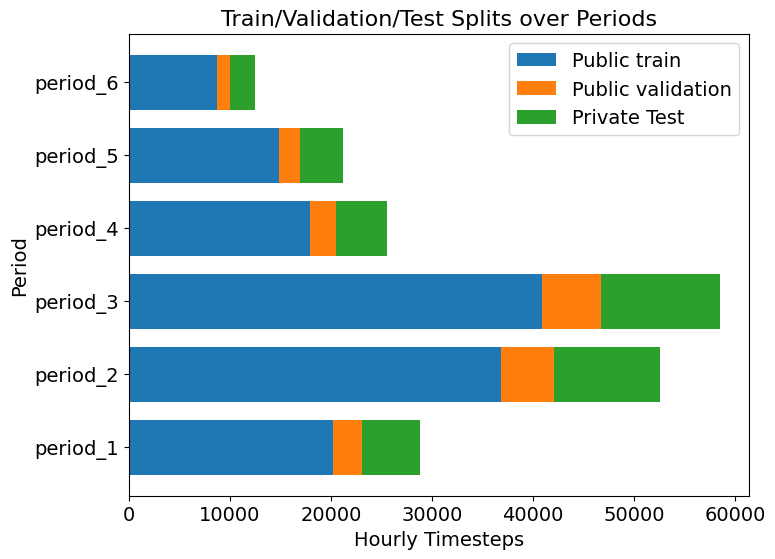

In [ ]:
plt.figure(figsize=[8,6])
ind = [0, 1, 2, 3, 4, 5]
names = data.groupby("period").size().reset_index(name="period_size")['period'].tolist()
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())


plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Public train", "Public validation", "Private Test"])
plt.show()

In [ ]:
print(train.shape)
train.head()

(139345, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                         
period_1 0 days 00:00:00  -7 -10.0  0.499705  2.443614         -0.375267   
         0 days 01:00:00 -10 -10.0  0.547177 -0.224580         -0.479430   
         0 days 02:00:00 -10  -6.0  0.739905 -0.770240         -0.574831   
         0 days 03:00:00  -6  -2.0  0.699098 -0.278783         -0.324709   
         0 days 04:00:00  -2   3.0  0.223933 -0.225168         -0.313432   

                          temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                   
period_1 0 days 00:00:00         0.383941    -1.600307   -0.381727   
         0 days 01:00:00         0.953178    -1.759200   -0.868044   
         0 days 02:00:00        -0.192518    -1.913422   -1.114649   
         0 days 03:00:00         0.325491    -1.810283   -0.783326   
         0 days 04:00:00         0.201600    -1.339730   -0.485151   

                          by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                           
period_1 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
         0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
         0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   
         0 days 03:00:00    -0.380282    0.330015     0.603107   -0.282789   
         0 days 04:00:00     0.080228    1.010471     0.454560   -0.471111   

                          speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                           
period_1 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
         0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
         0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   
         0 days 03:00:00   -0.826469  -0.211185     -0.404306     0.218373   
         0 days 04:00:00   -0.601238   1.016033     -0.371487     0.097253   

                          smoothed_ssn  
period   timedelta                      
period_1 0 days 00:00:00      0.139444  
         0 days 01:00:00      0.139444  
         0 days 02:00:00      0.139444  
         0 days 03:00:00      0.139444  
         0 days 04:00:00      0.139444

In [ ]:
print(val.shape)
val.head()

(19903, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                           
period_1 840 days 18:00:00 -13 -15.0  1.392218 -0.231998         -0.832243   
         840 days 19:00:00 -15  -6.0  1.504970  1.572159         -0.773590   
         840 days 20:00:00  -6   9.0  2.048136 -0.050704         -0.712973   
         840 days 21:00:00   9  20.0  2.508049  2.677117         -0.564033   
         840 days 22:00:00  20   6.0  2.553991  1.178737         -0.675644   

                            temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                     
period_1 840 days 18:00:00        -0.625576    -0.884754    0.285334   
         840 days 19:00:00        -0.564179    -0.880472    1.287087   
         840 days 20:00:00        -0.575063    -0.652058    0.498531   
         840 days 21:00:00        -0.420665     0.873139    6.276772   
         840 days 22:00:00        -0.525714     1.925257   -0.133193   

                            by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                             
period_1 840 days 18:00:00     1.088226    0.058739     2.689025   -0.383008   
         840 days 19:00:00     1.036716    0.024747     2.772788    0.561548   
         840 days 20:00:00     1.022013   -0.461213     3.602818   -0.282333   
         840 days 21:00:00    -1.152272    6.038927     2.281553    2.469630   
         840 days 22:00:00    -2.602307   -0.089212     2.523398    0.130254   

                            speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                             
period_1 840 days 18:00:00    0.121181  -0.326359      1.350632     1.186279   
         840 days 19:00:00    0.153219  -0.154259      2.494491     4.208981   
         840 days 20:00:00    0.153394  -0.268117      4.638751     0.792717   
         840 days 21:00:00    0.219035  -0.015680      7.002139     6.488986   
         840 days 22:00:00    0.271681  -0.536797      4.318423     2.724134   

                            smoothed_ssn  
period   timedelta                        
period_1 840 days 18:00:00      2.187904  
         840 days 19:00:00      2.187904  
         840 days 20:00:00      2.187904  
         840 days 21:00:00      2.187904  
         840 days 22:00:00      2.187904

In [ ]:
print(test.shape)
test.head()

(39808, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period   timedelta                                                           
period_1 960 days 20:00:00 -42 -36.0  3.721392 -0.276146         -0.898855   
         960 days 21:00:00 -36 -32.0  3.647589 -0.582626         -0.893382   
         960 days 22:00:00 -32 -26.0  3.554503 -0.406087         -0.806288   
         960 days 23:00:00 -26 -31.0  3.318674 -0.342302         -0.845912   
         961 days 00:00:00 -31 -26.0  3.085467 -0.217864         -0.873295   

                            temperature_std  bx_gsm_mean  bx_gsm_std  \
period   timedelta                                                     
period_1 960 days 20:00:00        -0.667413     1.148501   -0.312385   
         960 days 21:00:00        -0.652453     1.752888   -0.501719   
         960 days 22:00:00        -0.576025     2.033602   -0.807164   
         960 days 23:00:00        -0.561678     2.043235   -0.732169   
         961 days 00:00:00        -0.649855     1.977264   -0.723950   

                            by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period   timedelta                                                             
period_1 960 days 20:00:00     3.230311   -0.685351     3.975589   -0.423557   
         960 days 21:00:00     3.268373   -0.709411     3.556886   -0.732245   
         960 days 22:00:00     3.831348    0.140943     1.861229    1.384880   
         960 days 23:00:00     3.966892   -0.942138     0.190550    0.327249   
         961 days 00:00:00     3.788772   -0.658874    -0.331641   -0.467830   

                            speed_mean  speed_std  density_mean  density_std  \
period   timedelta                                                             
period_1 960 days 20:00:00   -0.457723  -0.657542      0.973881    -0.062592   
         960 days 21:00:00   -0.366080  -0.231337      0.910748     0.146483   
         960 days 22:00:00   -0.144989  -0.202363      1.446090     1.696120   
         960 days 23:00:00   -0.107399  -0.601914      0.396158     0.122446   
         961 days 00:00:00   -0.081434  -0.616191      0.666683    -0.151687   

                            smoothed_ssn  
period   timedelta                        
period_1 960 days 20:00:00      2.046631  
         960 days 21:00:00      2.046631  
         960 days 22:00:00      2.046631  
         960 days 23:00:00      2.046631  
         961 days 00:00:00      2.046631

### Load a Pre-Trained Model

#### Load Model, Scaler, History and Configuration

<div class="alert alert-block alert-success">
    <b>Exercise:</b> Choose from the following pre-trained models developed in the <b>Chapter 1</b> notebook.
</div>

<div class="alert alert-block alert-warning">
<b>Be Aware: </b>The smallest model size option in the <b>Chapter 1</b> notebook is set for notebook execution speed and training will not fully converge. In this notebook it's recommended that you load a model from <b>Chapter 1</b> that's at least as performant as the MagNet benchmark case for convergence and benchmark performance.
</div>

In [ ]:
from keras import preprocessing
import tensorflow as tf

data_config = {
    "timesteps": 128,#128
    "batch_size": 768, #128
}


def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
            shuffle=True
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds = timeseries_dataset_from_df(val, data_config["batch_size"])

print(f"Number of train batches: {len(train_ds)}")
print(f"Number of val batches: {len(val_ds)}")

Number of train batches: 181
Number of val batches: 27


## Model Development

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, Layer, Conv1D, Input, Concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense, Activation, Flatten
from tensorflow.keras.models import Sequential


# Define model configuration
model_config = {"n_epochs": 50, "n_neurons": 512, "dropout": 0.2, "stateful": False}

# Create a Sequential model
model = Sequential()

# Add the input layer
model.add(Input(shape=(data_config["timesteps"], len(XCOLS)), name='input_layer'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')))

# Encoder
model.add(Conv1D(64, 12, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(32, 12, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(Conv1D(16, 16, activation='relu', padding='same'))
model.add(MaxPooling1D(2, padding='same'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu')))

# Decoder
model.add(Conv1D(16, 12, activation='relu', padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(32, 12, activation='relu', padding='same'))
model.add(UpSampling1D(2))
model.add(Conv1D(64, 16, activation='relu'))
model.add(UpSampling1D(2))
model.add(Conv1D(1, 16, activation='selu', padding='same'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu')))
model.add(Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(Dense(2))


# Compile the model
learning_rate = 1e-4  # 4e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
acc = tf.keras.metrics.RootMeanSquaredError()

def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(
    loss=RMSE,
    optimizer=optimizer,
    metrics=[acc]
)

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 128, 32)          512       
 tributed)                                                       
                                                                 
 conv1d_28 (Conv1D)          (None, 128, 64)           24640     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 64, 64)           0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 64, 32)            24608     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 32, 32)           0         
 g1D)                                                            
                                                      

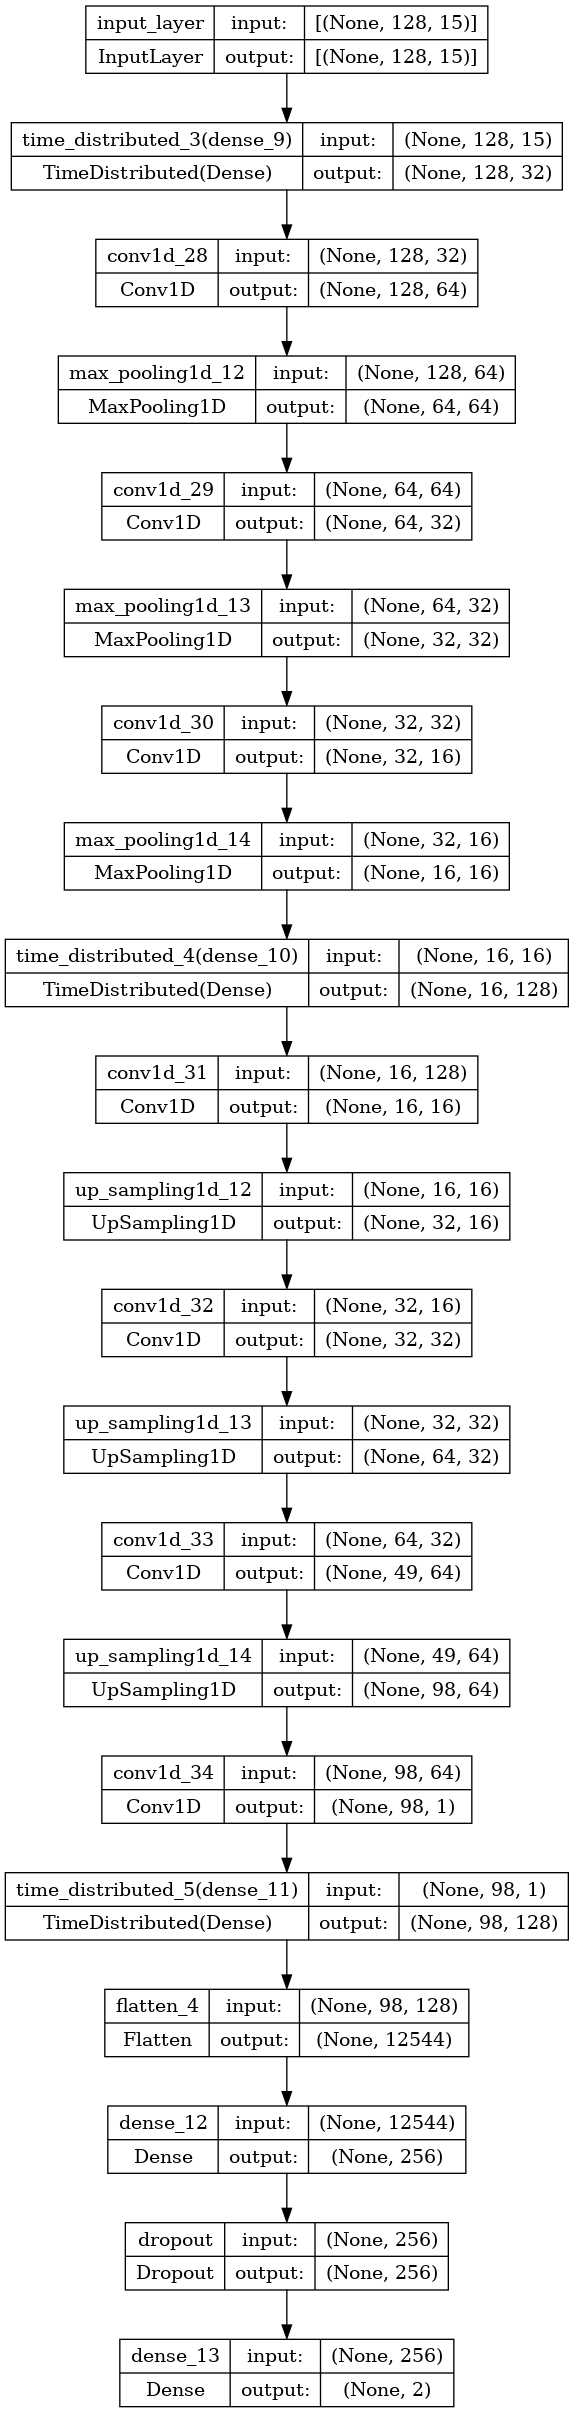

In [ ]:
tf.keras.utils.plot_model(model, to_file = 'nasc_model.png', show_shapes=True, show_layer_names = True)

In [ ]:

# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
#early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)

class ReduceLRBacktrack(tf.keras.callbacks.ReduceLROnPlateau):
    def __init__(self, best_path, *args, **kwargs):
        super(ReduceLRBacktrack, self).__init__(*args, **kwargs)
        self.best_path = best_path

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            logging.warning('Reduce LR on plateau conditioned on metric `%s` '
                            'which is not available. Available metrics are: %s',
                             self.monitor, ','.join(list(logs.keys())))
        if not self.monitor_op(current, self.best): # not new best
            if not self.in_cooldown(): # and we're not in cooldown
                if self.wait+1 >= self.patience: # going to reduce lr
                    # load best model so far
                    # print("\n Backtracking to best model before reducting LR")
                    self.model.load_weights(self.best_path)

        super().on_epoch_end(epoch, logs) # actually reduce LR

model_path = 'model.h5'

lr_reducer = ReduceLRBacktrack(
    best_path = model_path,
    monitor="val_loss",
    factor=0.5,
    patience=4,
    min_lr=1e-10,
    mode='min'
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    train_ds,
    batch_size=data_config["batch_size"],
    epochs = 50,
    #verbose=2,
    callbacks=[checkpoint, lr_reducer],
    #callbacks=[lr_reducer],
    shuffle=False,
    validation_data=val_ds,
)

Epoch 1/50
181/181 [==============================] - 39s 173ms/step - loss: 16.0509 - root_mean_squared_error: 16.8361 - val_loss: 12.4234 - val_root_mean_squared_error: 13.3598 - lr: 1.0000e-04
Epoch 2/50
181/181 [==============================] - 26s 137ms/step - loss: 12.2423 - root_mean_squared_error: 12.6439 - val_loss: 12.1886 - val_root_mean_squared_error: 13.3758 - lr: 1.0000e-04
Epoch 3/50
181/181 [==============================] - 26s 140ms/step - loss: 11.1322 - root_mean_squared_error: 11.4473 - val_loss: 12.1177 - val_root_mean_squared_error: 13.4734 - lr: 1.0000e-04
Epoch 4/50
181/181 [==============================] - 28s 151ms/step - loss: 10.4784 - root_mean_squared_error: 10.7803 - val_loss: 12.7087 - val_root_mean_squared_error: 14.4682 - lr: 1.0000e-04
Epoch 5/50
181/181 [==============================] - 27s 142ms/step - loss: 9.9841 - root_mean_squared_error: 10.2679 - val_loss: 12.3145 - val_root_mean_squared_error: 13.9845 - lr: 1.0000e-04
Epoch 6/50
181/181 [=

#### BatchDataset: Training, Validation and Test Data
In order to evaluate / test our Pre-trained model, we'll create <i>[tensorflow.python.data.ops.dataset_ops.BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements)</i> structures for our Test DataFrames.

In [ ]:
import tensorflow.keras as keras
from keras import preprocessing

def timeseries_dataset_from_df(df, batch_size):
    """Provides a batched dataset as pd.DataFrame

    Parameters
    ----------
    df : pd.DataFrame
    batch_size : int

    Returns
    -------
    dataset : pd.DataFrame
        Batched data.
    """

    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)

    return dataset

test_ds  = timeseries_dataset_from_df(test,  data_config["batch_size"])

print(f"Number of test batches: {len(test_ds)}")

Number of test batches: 53


### Evaluate Trained Model

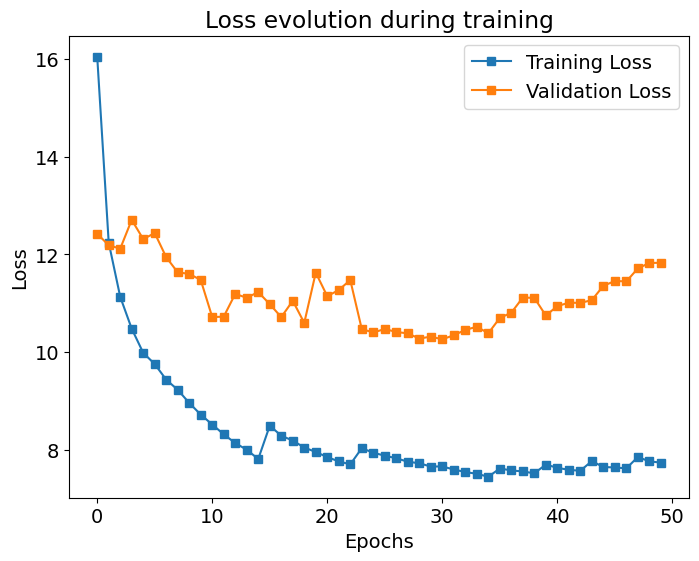

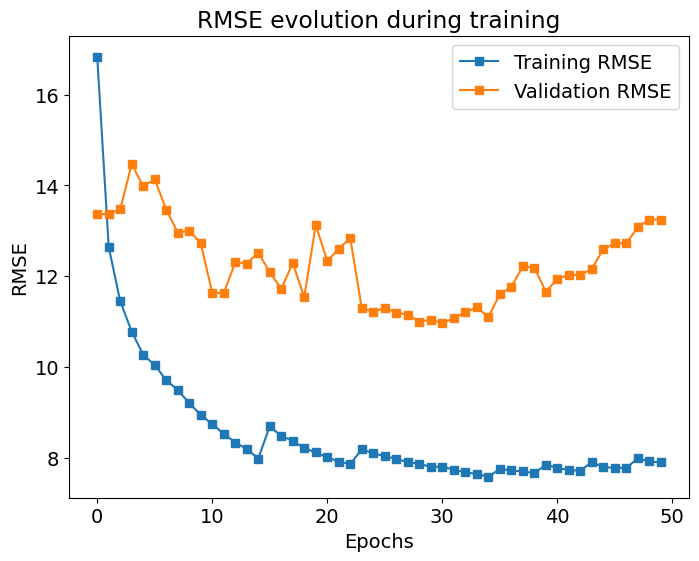

In [ ]:
def plot_learning_evolution(r):
    plt.figure(figsize=(8, 6))

    #plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], 's-', label='Training Loss')
    plt.plot(r.history['val_loss'], 's-', label='Validation Loss')
    plt.title('Loss evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('loss.png')

    plt.figure(figsize=(8, 6))
    #plt.subplot(2, 2, 2)
    plt.plot(r.history['root_mean_squared_error'], 's-', label='Training RMSE')
    plt.plot(r.history['val_root_mean_squared_error'], 's-', label='Validation RMSE')
    plt.title('RMSE evolution during training')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.savefig('rmse.png')

plot_learning_evolution(history)

In [ ]:
rmse = model.evaluate(test_ds)
print(f"Test RMSE: {rmse[1]:.2f} nano-Tesla")

53/53 [==============================] - 6s 120ms/step - loss: 9.5591 - root_mean_squared_error: 10.6323
Test RMSE: 10.63 nano-Tesla
